In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

#normalisation : on souhaite centrer les données autour de 0
transform = transforms.Compose([ #applique a tous
    transforms.ToTensor(), #on met en Tenseur(3d) que pytorch apprécie (couleurs, hauteurs, largeurs) il divise également par 255
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # .Normalize((mean,), (std,))   Xnorm=(X-moy)/écart-type 
])
#On a maintenant des données sous forme de vecteurs entre -1 et 1

#chargement du bloc "Train" présent dans torchvision (50 000 images)
dataset_complet = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# SPLIT : On garde 10 000 images pour la validation
train_set, val_set = random_split(dataset_complet, [40000, 10000])

# chargement du bloc "Test" de torchvision (10 000 images)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#création des "distributeurs" (Loaders)
# batch_size a 32 est un bon compromis, on les envoie 32 par 32
# shuffle True mélange les cartes une fois le data set complet fait, vital pour éviter un apprentissage dans l'ordre 
train_loader = DataLoader(train_set, batch_size=32, shuffle=True) 
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

Train: 40000, Val: 10000, Test: 10000


In [17]:
import torch.nn as nn
import torch.nn.functional as F

# On a 5 couches :
# 2 de convolutions
# conv1 : Apprend des filtres simples.
# conv2 : Apprend des formes plus complexes.
# 3 linéaires
# fc1 : Première étape du raisonnement
# fc2 : Deuxième étape du raisonnement
# fc3 : Conclusion (choix parmi les 10 classes)
class MonReseau(nn.Module):
    def __init__(self):
        super(MonReseau, self).__init__()

        '''On définit ici les outils qui possèdent des poids que l'IA va apprendre'''

        # Pooling
        # Arguments : (kernel_size, stride)
        #SIZE   2 : carré 2*2  et on veut garder que la valeur la plus forte ("max")
        #STRIDE 2 : on fait 2 pixels par 2 pixels (pas de chevauchement), donc on divise la taille par 2.
        self.pool = nn.MaxPool2d(2, 2) #"Max" signifie qu'on ne garde que le pixel ayant la plus forte intensité.

        # ---couche 1---
        #Convolution
        # Arguments : (in_channels, out_channels, kernel_size)
        # IN    3 : Entrée RGB (Rouge, Vert, Bleu).
        # OUT   6 : Le réseau va créer 6 "filtres" différents (cherche 6 types de motifs).
        # SIZE  5 : Taille du filtre (5x5 pixels).
        self.conv1 = nn.Conv2d(3, 6, 5)
        '''effet fenêtre : Taille_sortie = (Taille_entrée - Taille_kernel) + 1'''
        # ICI 32-5+1=28
        
        # ---couche 2---
        #convolution
        # 6 : On reçoit les 6 filtres de la couche précédente.
        # 16 : On crée 16 nouveaux filtres plus complexes.
        # 5 : Taille 5x5.
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # ---couches linéaires (Le cerveau final)---
        # Arguments : (in_features, out_features)
        # IN:   16*5*5 : On a 16 images de 5x5 pixels à la fin des convolutions.
        # OUT:  120 : On projette ces 400 points sur 120 neurones.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        # 120 -> 84 neurones (on affine la pensée).
        self.fc2 = nn.Linear(120, 84)
        
        # 84 -> 10 neurones (un pour chaque classe : chat, chien, etc.).
        self.fc3 = nn.Linear(84, 10)

        #pourquoi 120 et 84 ? valeurs historiques issues du réseau LeNet-5
        
        #Pourquoi pas + de couches ? 
        # eviter l'overfitting, un réseau trop complexe par rapport au problème risque l'overfitting
        # de plus, + de couches va trop réduire la taille de l'image 
        # et également le temps de calcul
    
    def forward(self, x):

        """
        Cette fonction définit le CHEMIN (Le "Comment"). 
        'x' représente tes données d'entrée
        Au départ, x a la forme : (Batch_Size, 3, 32, 32)
        """
        
        # PREMIÈRE COUCHE DE TRAITEMENT
        # On applique la convolution, puis on "casse" la linéarité avec ReLU, puis on compresse avec le Pooling.
        # Transformation : (3, 32, 32) -> (6, 28, 28) -> (6, 14, 14) 
        # (3, 32, 32) -> (6, 28, 28) effet fenêtre : Taille_sortie = (Taille_entrée - Taille_kernel) + 1
        # (6, 28, 28) -> (6, 14, 14) pooling (ici division par 2)
        x = self.pool(F.relu(self.conv1(x)))

        # DEUXIÈME COUCHE DE TRAITEMENT
        # On répète l'opération pour détecter des motifs plus complexes.
        # Transformation : (6, 14, 14) -> (16, 10, 10) -> (16, 5, 5) ; de même
        x = self.pool(F.relu(self.conv2(x)))
        
        # APPLATISSEMENT
        # Les couches linéaires ne veulent une ligne
        # torch.flatten transforme notre cube (16, 5, 5) en un vecteur de 400 chiffres
        # image par image, ligne par ligne.
        # On met '1' pour ne pas écraser la dimension du Batch.
        x = torch.flatten(x, 1) 
        
        # RÉFLEXION (Couches Linéaires)
        # Chaque neurone de fc1 va regarder les 400 chiffres pour en déduire 120 caractéristiques.
        x = F.relu(self.fc1(x))
        # On affine encore la pensée : on passe de 120 à 84 concepts.
        x = F.relu(self.fc2(x))
        
        # DÉCISION FINALE
        # On arrive aux 10 scores finaux. 
        # ATTENTION : On n'utilise pas ReLU ici ! 
        # On veut les scores bruts (Logits) pour que la CrossEntropyLoss puisse travailler.
        x = self.fc3(x)
        
        return x # Le réseau renvoie ses 10 scores de prédiction

In [ ]:
import torch.optim as optim

# 1. On instancie le réseau
net = MonReseau()

# 2. On définit l'arbitre (Loss car dans cette bdd les proportions sont respectés alors pas de recall par exemple.)
# CrossEntropyLoss combine LogSoftmax et NLLLoss en une seule fonction.
# Idéal pour la classification car elle punit les mauvaises certitudes.
criterion = nn.CrossEntropyLoss()

# 3. On définit l'Optimiseur : SGD (Stochastic Gradient Descent)
# net.parameters() : Les variables que l'optimiseur peut modifier
# lr=0.001 : "Learning Rate". La taille du pas de correction.
# momentum=0.9 : Ajoute une fraction du mouvement précédent pour ne pas rester bloqué dans un creux local.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_losses = []
val_losses = []

epochs = 10 # 10 époques pour voir l'évolution

In [19]:
#apprentissage 

print("Début de l'entraînement...")

for epoch in range(epochs):
    # --- PHASE 1 : ENTRAÎNEMENT (Apprentissage) ---
    net.train() # Mode apprentissage activé
    running_train_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # A. On efface les anciens calculs de correction (Gradients)
        optimizer.zero_grad()

        # B. Passage vers l'avant (Forward) : Le réseau devine
        outputs = net(inputs)

        # C. Calcul de l'erreur (Loss)
        loss = criterion(outputs, labels)

        # D. Passage vers l'arrière (Backward) : Calcul des corrections nécessaires
        loss.backward()

        # E. Mise à jour (Step) : L'optimiseur change les poids des neurones
        optimizer.step()

        running_train_loss += loss.item()

    # --- PHASE 2 : VALIDATION (Examen blanc) ---
    net.eval() # Mode évaluation : on fige les neurones
    running_val_loss = 0.0
    
    with torch.no_grad(): # Désactive le calcul des gradients (gain de vitesse + mémoire)
        for data in val_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # --- PHASE 3 : DIAGNOSTIC ---
    # On calcule la perte moyenne pour cette époque
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Époque [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("Entraînement terminé !")

Début de l'entraînement...
Époque [1/10] | Train Loss: 2.2743 | Val Loss: 2.1279
Époque [2/10] | Train Loss: 1.9305 | Val Loss: 1.8107
Époque [3/10] | Train Loss: 1.6847 | Val Loss: 1.5832
Époque [4/10] | Train Loss: 1.5238 | Val Loss: 1.4552
Époque [5/10] | Train Loss: 1.4265 | Val Loss: 1.3889
Époque [6/10] | Train Loss: 1.3585 | Val Loss: 1.3388
Époque [7/10] | Train Loss: 1.3009 | Val Loss: 1.2955
Époque [8/10] | Train Loss: 1.2562 | Val Loss: 1.2970
Époque [9/10] | Train Loss: 1.2180 | Val Loss: 1.2338
Époque [10/10] | Train Loss: 1.1788 | Val Loss: 1.1947
Entraînement terminé !


***Pourquoi la loss commence à 2.3 et tend vers 0 ?***

Le hasard total : Au tout début, les neurones ont des poids aléatoires. Le modèle n'a aucune préférence. Il a donc 1 chance sur 10 de deviner la bonne réponse, soit une probabilité **p = 0.1**.

La fonction CrossEntropy : La fonction de perte que nous utilisons calcule l'opposé du logarithme népérien de la probabilité de la bonne classe.

Loss ~= -ln(0.1) ~= ln(10) ~= 2.302

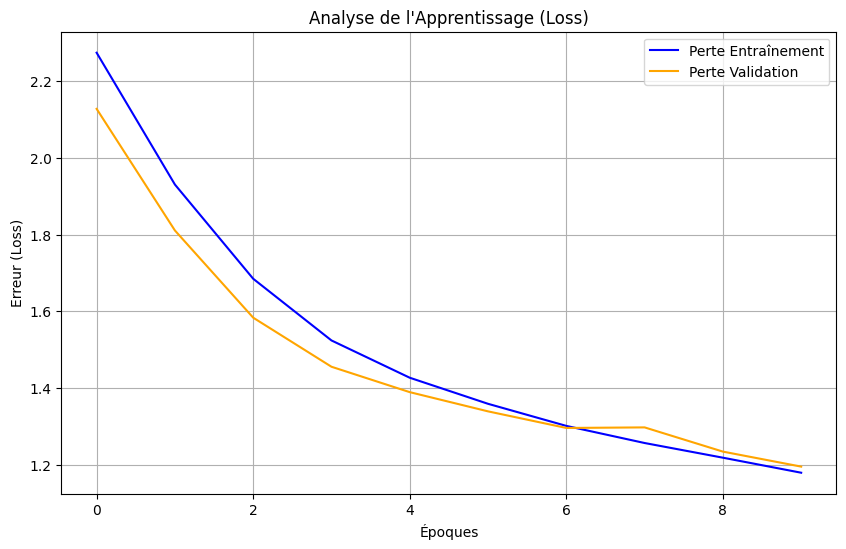

In [20]:
#traçage des graphes :
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Perte Entraînement', color='blue')
plt.plot(val_losses, label='Perte Validation', color='orange')
plt.title('Analyse de l\'Apprentissage (Loss)')
plt.xlabel('Époques')
plt.ylabel('Erreur (Loss)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# %pip install seaborn pandas scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 11.0/11.0 MB 57.7 MB/s  0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------  7.9/8.0 MB 37.9 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 33.5 MB/s  0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ------------------- -------------------- 18.6/38.5 MB 87.7 MB/s eta 0:00:01
   -------------------------------------- - 37.2/38.5 MB 91.0 MB/s eta 0:00:01
   ---------------------------------------- 38.5/38.5 MB 70.7 MB/s  0:00:00

   ---------------------------------------- 0/8 [pytz]
   ---------------------------------------- 0/8 [pytz]
   ---------------------------------------- 0/8 [pytz]
   ---------------------------------------- 0/8 [pytz]
   ---------------------------------------- 0/8 [pytz]
   ---------------------------------------- 0/8 [pytz]


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


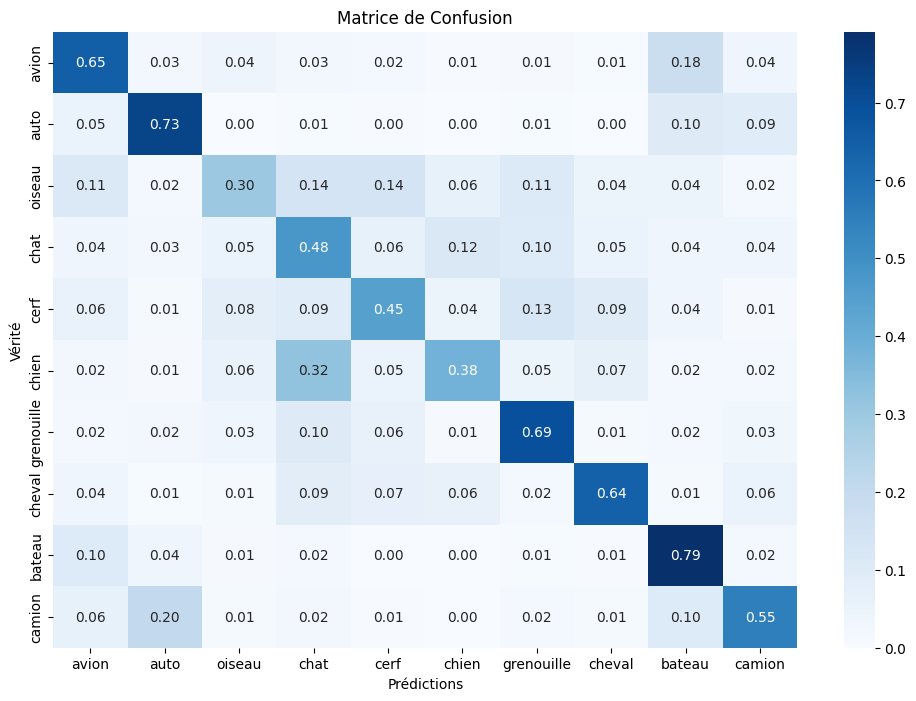

In [25]:
# matrice de confusion 

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

# basculage du réseau en mode évaluation
net.eval()

y_pred = []
y_true = []

# parcourt du set de TEST
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1) # On prend l'indice du score max
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

# Préparation des étiquettes
classes = ('avion', 'auto', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion')
cf_matrix = confusion_matrix(y_true, y_pred)

#Affichage graphique
# On normalise par ligne pour avoir des pourcentages (0 à 1)
df_cm = pd.DataFrame(cf_matrix / cf_matrix.sum(axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Prédictions')
plt.ylabel('Vérité')
plt.title('Matrice de Confusion')
plt.show()

In [26]:
'''
Meilleur prédiction sur le bateau
On voit que le modèle a beaucoup de mal a distingué chien et chat par exemple
Résultat étonnament bon sur la grenouille selon moi.
On voit également que le coté métallique des bateaux avions camions voitures trompent le modèle.
'''

# Je vais désormais améliorer le modèle pour avoir de meilleurs résultats

'\nMeilleur prédiction sur le bateau\nOn voit que le modèle a beaucoup de mal a distingué chien et chat par exemple\nRésultat étonnament bon sur la grenouille selon moi.\nOn voit également que le coté métallique des bateaux avions camions voitures trompent le modèle.\n'

In [27]:
class MonReseauAmeliore(nn.Module):
    def __init__(self):
        super(MonReseauAmeliore, self).__init__()
        # BLOC 1 : Détection de motifs simples
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # 32 filtres au lieu de 6
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1) # on donne plusieurs chances au réseau d'extraire les bonnes infos
        self.pool = nn.MaxPool2d(2, 2)
        
        # BLOC 2 : Détection de motifs complexes
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # On monte à 64 filtres
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1) #idem
        
        # COUCHES DE DÉCISION
        # Après deux MaxPool, l'image 32x32 est devenue 8x8
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Passage dans le premier bloc
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x))) #pooling après deux passages dans le bloc motif simple (réduction de dimension)
        
        # Passage dans le deuxième bloc
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x))) #pooling après deux passages dans le bloc motif complexe
        
        # Aplatissement
        x = torch.flatten(x, 1)
        
        # Décision
        x = F.relu(self.fc1(x)) #on passe de 64*8*8 à 512
        x = self.fc2(x) #512->10 (nb de classes donc décision finale)
        return x

# On crée un nouveau réseau pour le model améliorer
net_ameliore = MonReseauAmeliore()

criterion = nn.CrossEntropyLoss() # le même
optimizer = optim.SGD(net_ameliore.parameters(), lr=0.001, momentum=0.9) #idem

train_losses_ameliore = []
val_losses_ameliore = []

epochs = 10 #idem

#apprentissage 
print("Début de l'entraînement...")

for epoch in range(epochs):
    # --- PHASE 1 : ENTRAÎNEMENT (Apprentissage) ---
    net_ameliore.train() # Mode apprentissage activé
    running_train_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # A. On efface les anciens calculs de correction (Gradients)
        optimizer.zero_grad()

        # B. Passage vers l'avant (Forward) : Le réseau devine
        outputs = net_ameliore(inputs)

        # C. Calcul de l'erreur (Loss)
        loss = criterion(outputs, labels)

        # D. Passage vers l'arrière (Backward) : Calcul des corrections nécessaires
        loss.backward()

        # E. Mise à jour (Step) : L'optimiseur change les poids des neurones
        optimizer.step()

        running_train_loss += loss.item()

    # --- PHASE 2 : VALIDATION (Examen blanc) ---
    net_ameliore.eval() # Mode évaluation : on fige les neurones
    running_val_loss = 0.0
    
    with torch.no_grad(): # Désactive le calcul des gradients (gain de vitesse + mémoire)
        for data in val_loader:
            inputs, labels = data
            outputs = net_ameliore(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # --- PHASE 3 : DIAGNOSTIC ---
    # On calcule la perte moyenne pour cette époque
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    
    train_losses_ameliore.append(avg_train_loss)
    val_losses_ameliore.append(avg_val_loss)

    print(f"Époque [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("Entraînement terminé !")

Début de l'entraînement...
Époque [1/10] | Train Loss: 2.2181 | Val Loss: 1.9684
Époque [2/10] | Train Loss: 1.7866 | Val Loss: 1.6567
Époque [3/10] | Train Loss: 1.5247 | Val Loss: 1.4310
Époque [4/10] | Train Loss: 1.3680 | Val Loss: 1.3365
Époque [5/10] | Train Loss: 1.2473 | Val Loss: 1.2822
Époque [6/10] | Train Loss: 1.1368 | Val Loss: 1.1389
Époque [7/10] | Train Loss: 1.0264 | Val Loss: 1.1116
Époque [8/10] | Train Loss: 0.9172 | Val Loss: 1.0324
Époque [9/10] | Train Loss: 0.8207 | Val Loss: 1.0135
Époque [10/10] | Train Loss: 0.7200 | Val Loss: 0.9547
Entraînement terminé !


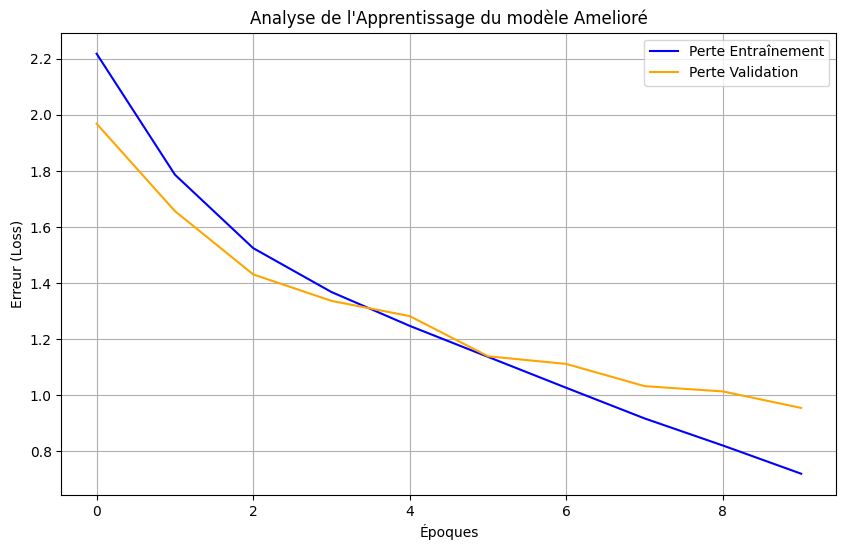

In [31]:
#traçage des graphes :

plt.figure(figsize=(10, 6))
plt.plot(train_losses_ameliore, label='Perte Entraînement', color='blue')
plt.plot(val_losses_ameliore, label='Perte Validation', color='orange')
plt.title('Analyse de l\'Apprentissage du modèle Amelioré')
plt.xlabel('Époques')
plt.ylabel('Erreur (Loss)')
plt.legend()
plt.grid(True)
plt.show()

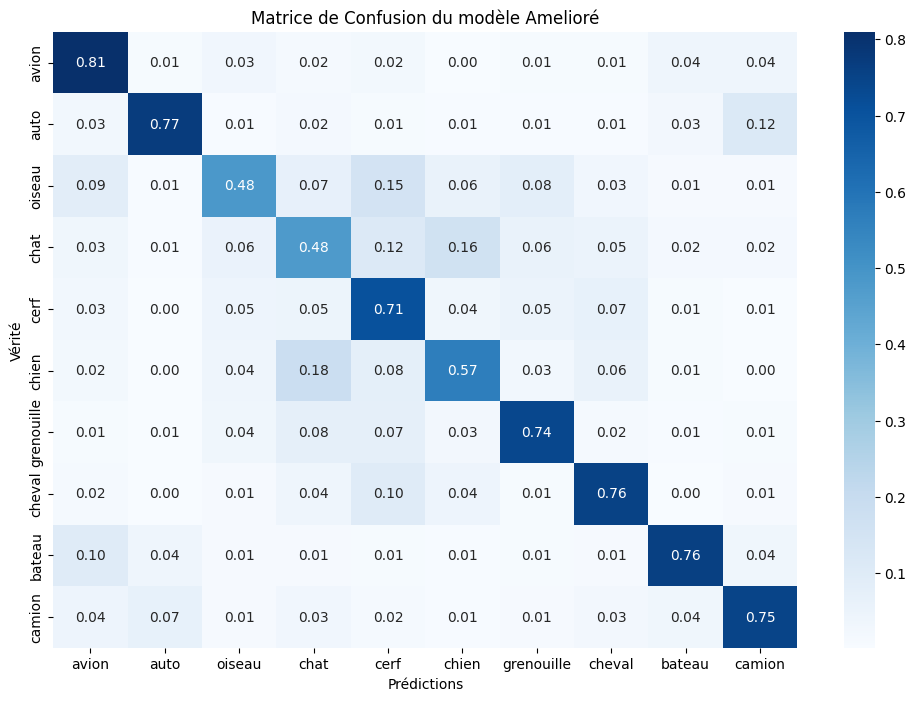

In [30]:
# matrice de confusion 

# basculage du réseau en mode évaluation
net_ameliore.eval()

y_pred = []
y_true = []

# parcourt du set de TEST
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net_ameliore(images)
        _, predicted = torch.max(outputs, 1) # On prend l'indice du score max
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

# Préparation des étiquettes
classes = ('avion', 'auto', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion')
cf_matrix = confusion_matrix(y_true, y_pred)

#Affichage graphique
# On normalise par ligne pour avoir des pourcentages (0 à 1)
df_cm = pd.DataFrame(cf_matrix / cf_matrix.sum(axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Prédictions')
plt.ylabel('Vérité')
plt.title('Matrice de Confusion du modèle Amelioré')
plt.show()


Les confusions comme avion / bateau ou chien / chat ont été beaucoup réduites. 

Les confusions entres animaux sont toujours très présentes


Ce modèle est beaucoup mieux mais je veux explorer les différentes façon de l'améliorer.

Je vais donc faire de la **Data Augmentation**


In [ ]:
from torch.utils.data import Subset

# --- séparation pipelines train/val/test ---
''' On veut des données d'entrainements modifiées et des données de validation et test propres.

    Mais les données de validation étant prises parmi les données de Test, et ne pouvant pas les séparer avant transformations,
    on va donc leurs donner un indice pour éviter les problèmes avec le shuffle et en chargeant 2 fois avec 2 transfo différentes,
    cela fera l'affaire.
'''
# Pipeline d'ENTRAÎNEMENT 
# On ajoute du bruit et des variations pour forcer le modèle à ne pas apprendre par coeur.
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),      # un chat peut regarder à gauche ou à droite
    transforms.RandomRotation(10),               # une photo n'est pas toujours droite
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # objets décentrés
    transforms.ColorJitter(brightness=0.2),      #variations de lumière (nuages, ombre)
    transforms.ToTensor(),                       
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

# Pipeline de  TEST 
# On ne transforme jamais ces images. On veut tester le modèle sur des photos "propres".
test_transform = transforms.Compose([ #images test
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Pipeline de  VALIDATION (idem que test il faut des données propres)

# On charge le dataset deux fois avec des noms différents pour appliquer les deux transformations.
# !!! -> En mémoire, les images brutes ne sont pas dupliquées, PyTorch est intelligent.
full_data_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
full_data_clean = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)

# Pour être sûr que les 10 000 images de validation soient les MÊMES dans les deux versions,
# on fixe manuellement les indices.
indices = list(range(50000))
train_indices = indices[:40000] # Les 40 000 premières pour apprendre
val_indices = indices[40000:]   # Les 10 000 dernières pour valider

# On crée les sous-groupes (Subsets)
# On pioche dans la version AUGMENTÉE pour le train
train_set = Subset(full_data_augmented, train_indices)
# On pioche dans la version PROPRE pour la validation 
val_set = Subset(full_data_clean, val_indices)

# On charge aussi le set de TEST final (toujours propre)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# --- CRÉATION DES LOADERS ---

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print(f"Prêt ! Train: {len(train_set)} images (augmentées) | Val: {len(val_set)} images (propres)")

c:\Users\Nolan\OneDrive\Documents\projet_pytorch\venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Prêt ! Train: 40000 images (augmentées) | Val: 10000 images (propres)


In [34]:
import torch.optim as optim

# A. On crée le nouveau réseau
net_augmente = MonReseauAmeliore()

# B. On crée l'arbitre
criterion = nn.CrossEntropyLoss()

# C. ON RE-CRÉE LE MÉCANICIEN (L'Optimizer) 
# C'est l'étape cruciale : on lie l'optimiseur aux NOUVEAUX paramètres de net
optimizer = optim.SGD(net_augmente.parameters(), lr=0.001, momentum=0.9)



In [35]:
# entraînement améliorée

# Configuration
epochs = 30
best_val_loss = float('inf') # On commence avec une erreur "infinie"

# Historiques pour les graphes
train_losses_augmente = []
val_losses_augmente = []

print("Lancement de l'entraînement musclé avec Data Augmentation...")

for epoch in range(epochs):
    # --- PHASE D'ENTRAÎNEMENT ---
    net_augmente.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = net_augmente(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # --- PHASE DE VALIDATION ---
    net_augmente.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = net_augmente(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Calcul des moyennes
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(val_loader)
    train_losses_augmente.append(epoch_train_loss)
    val_losses_augmente.append(epoch_val_loss)

    # --- SAUVEGARDE DU MEILLEUR MODÈLE ( ou Checkpoint) ---
    # Si l'erreur actuelle est plus basse que notre meilleur score historique :
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        # On enregistre les poids du réseau dans un fichier
        torch.save(net_augmente.state_dict(), 'meilleur_modele.pth')
        print(f" Époque {epoch+1} : Nouveau meilleur modèle sauvegardé ! (Loss: {epoch_val_loss:.4f})")
    else:
        print(f"Époque {epoch+1} : Train Loss {epoch_train_loss:.4f} | Val Loss {epoch_val_loss:.4f}")

print("Entraînement terminé !")

Lancement de l'entraînement musclé avec Data Augmentation...
 Époque 1 : Nouveau meilleur modèle sauvegardé ! (Loss: 2.2881)
 Époque 2 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.9517)
 Époque 3 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.8180)
 Époque 4 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.7006)
 Époque 5 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.6787)
 Époque 6 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.5549)
 Époque 7 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.5090)
 Époque 8 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.4597)
 Époque 9 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.4363)
 Époque 10 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.3761)
 Époque 11 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.3530)
 Époque 12 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.3243)
 Époque 13 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.2568)
 Époque 14 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.2368)
 Époque 15 : Nouveau meilleur modèle s

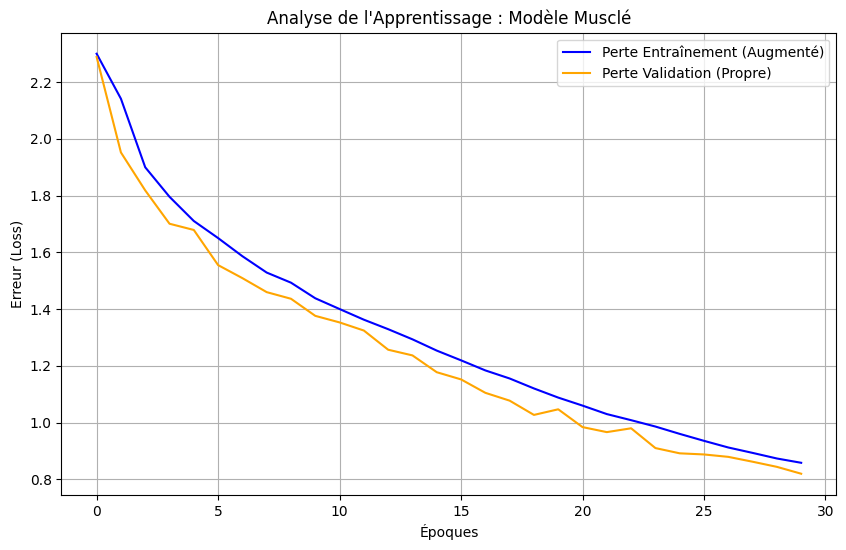

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_augmente, label='Perte Entraînement (Augmenté)', color='blue')
plt.plot(val_losses_augmente, label='Perte Validation (Propre)', color='orange')
plt.title('Analyse de l\'Apprentissage : Modèle Musclé')
plt.xlabel('Époques')
plt.ylabel('Erreur (Loss)')
plt.legend()
plt.grid(True)
plt.show()

On voit une très bonne progression d'apprentissage !


Précision moyenne du modèle : 71.29 %
Précision pour avion : 79.4 %
Précision pour auto : 86.0 %
Précision pour oiseau : 53.2 %
Précision pour chat : 53.8 %
Précision pour cerf : 60.4 %
Précision pour chien : 57.2 %
Précision pour grenouille : 80.2 %
Précision pour cheval : 84.4 %
Précision pour bateau : 78.6 %
Précision pour camion : 79.7 %


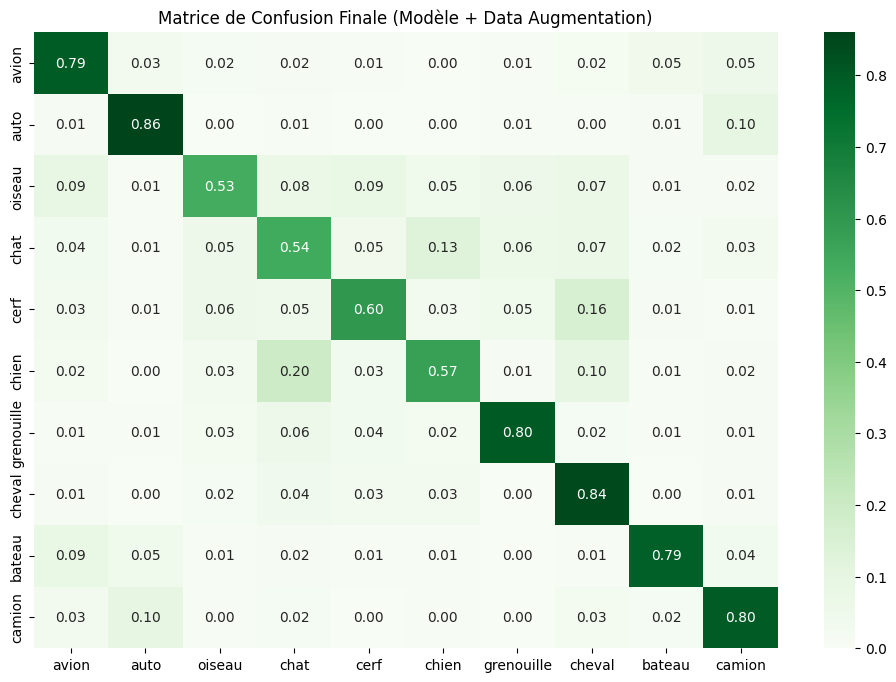

In [40]:
# --- RECHARGER LE MEILLEUR ---
net_augmente.load_state_dict(torch.load('meilleur_modele.pth'))
net_augmente.eval() # On fige le modèle

y_pred = []
y_true = []
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Le reste du code est identique
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net_augmente(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

        #calcul précision moyenne
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #précision par classe
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Calcul du pourcentage final
accuracy_moyenne = 100 * correct / total
print(f'Précision moyenne du modèle : {accuracy_moyenne:.2f} %')
# Affichage des résultats par classe
for i in range(10):
    print(f'Précision pour {classes[i]} : {100 * class_correct[i] / class_total[i]:.1f} %')

classes = ('avion', 'auto', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion')
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / cf_matrix.sum(axis=1)[:, None], index=classes, columns=classes)

plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='.2f') # On change en vert pour fêter le nouveau score !
plt.title('Matrice de Confusion Finale (Modèle + Data Augmentation)')
plt.show()

Avec ces résultats, on ne dirait pas que la data augmentation ait changé grand chose au modèle, elle l'a juste complexifier.

Pour essayer de rendre les résultats sur les animaux meilleurs, je vais tester la Batch Normalization qui devraient rendre les résultats propres et stables entre les différentes couches de neuronnes.

Je vais donc d'abord faire un modèle avec des BN puis je rajouterai la data augmentation.

In [ ]:
'''
Création du même modèle en rajoutant des BN,
puis je vais essayer de rajouter une couches linéaires entre 512 et 10 (4096->512->64->10)
puis dans les codes suivants je vais l'assembler avec la data augmentation

avant de rajouter la couche linéaire j'obtiens ceci :
Précision moyenne du modèle : 76.62 %
Précision pour avion : 81.0 %
Précision pour auto : 80.9 %
Précision pour oiseau : 59.8 %
Précision pour chat : 63.8 %
Précision pour cerf : 77.7 %
Précision pour chien : 62.9 %
Précision pour grenouille : 83.3 %
Précision pour cheval : 80.6 %
Précision pour bateau : 90.1 %
Précision pour camion : 86.1 %

après ajout de la couche :
Précision moyenne du modèle : 74.44 %
Précision pour avion : 77.0 %
Précision pour auto : 81.6 %
Précision pour oiseau : 54.5 %
Précision pour chat : 47.5 %
Précision pour cerf : 75.6 %
Précision pour chien : 75.8 %
Précision pour grenouille : 73.0 %
Précision pour cheval : 82.7 %
Précision pour bateau : 86.3 %
Précision pour camion : 90.4 %
'''

class MonReseauUltimate(nn.Module):
    def __init__(self):
        super(MonReseauUltimate, self).__init__()
        # BLOC 1 : 32 filtres
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Stabilisateur
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) # Stabilisateur
        self.pool = nn.MaxPool2d(2, 2)
        
        # BLOC 2 : 64 filtres
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) # Stabilisateur
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64) # Stabilisateur
        
        # COUCHES DE DÉCISION
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 64) #10 en 64
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Bloc 1 : Conv -> BN -> ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Bloc 2 : Conv -> BN -> ReLU
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

# On crée un nouveau réseau pour le modèle avec BN
net_ultimate = MonReseauUltimate()

criterion = nn.CrossEntropyLoss() # le même
optimizer = optim.SGD(net_ultimate.parameters(), lr=0.001, momentum=0.9) #idem

train_losses_ultimate = []
val_losses_ultimate = []

epochs = 10 #idem

#apprentissage 
print("Début de l'entraînement...")

for epoch in range(epochs):
    # --- PHASE 1 : ENTRAÎNEMENT (Apprentissage) ---
    net_ultimate.train() # Mode apprentissage activé
    running_train_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # A. On efface les anciens calculs de correction (Gradients)
        optimizer.zero_grad()

        # B. Passage vers l'avant (Forward) : Le réseau devine
        outputs = net_ultimate(inputs)

        # C. Calcul de l'erreur (Loss)
        loss = criterion(outputs, labels)

        # D. Passage vers l'arrière (Backward) : Calcul des corrections nécessaires
        loss.backward()

        # E. Mise à jour (Step) : L'optimiseur change les poids des neurones
        optimizer.step()

        running_train_loss += loss.item()

    # --- PHASE 2 : VALIDATION (Examen blanc) ---
    net_ultimate.eval() # Mode évaluation : on fige les neurones
    running_val_loss = 0.0
    
    with torch.no_grad(): # Désactive le calcul des gradients (gain de vitesse + mémoire)
        for data in val_loader:
            inputs, labels = data
            outputs = net_ultimate(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # --- PHASE 3 : DIAGNOSTIC ---
    # On calcule la perte moyenne pour cette époque
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    
    train_losses_ultimate.append(avg_train_loss)
    val_losses_ultimate.append(avg_val_loss)

    print(f"Époque [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("Entraînement terminé !")

Début de l'entraînement...
Époque [1/10] | Train Loss: 1.7607 | Val Loss: 1.4382
Époque [2/10] | Train Loss: 1.3506 | Val Loss: 1.1959
Époque [3/10] | Train Loss: 1.1892 | Val Loss: 1.0953
Époque [4/10] | Train Loss: 1.0793 | Val Loss: 0.9223
Époque [5/10] | Train Loss: 1.0128 | Val Loss: 0.9675
Époque [6/10] | Train Loss: 0.9570 | Val Loss: 0.8541
Époque [7/10] | Train Loss: 0.9140 | Val Loss: 0.8376
Époque [8/10] | Train Loss: 0.8762 | Val Loss: 0.9245
Époque [9/10] | Train Loss: 0.8482 | Val Loss: 0.7268
Époque [10/10] | Train Loss: 0.8032 | Val Loss: 0.7433
Entraînement terminé !


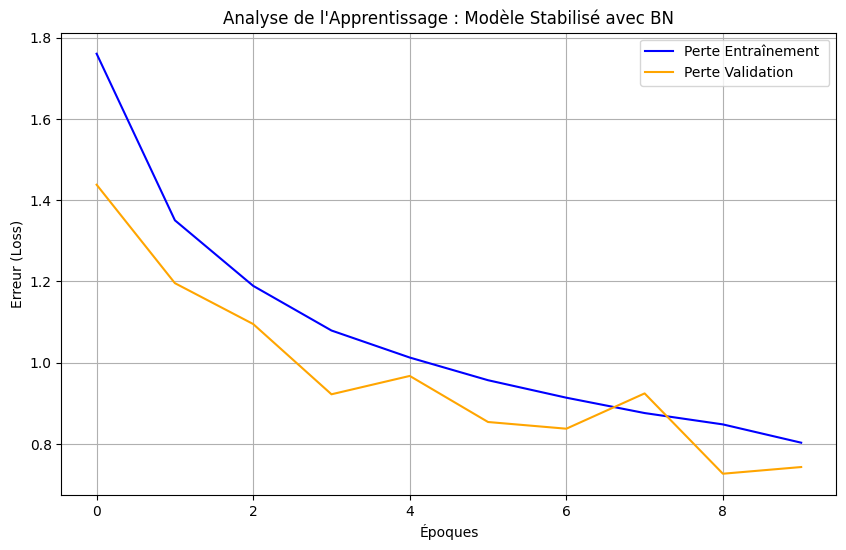

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_ultimate, label='Perte Entraînement ', color='blue')
plt.plot(val_losses_ultimate, label='Perte Validation ', color='orange')
plt.title('Analyse de l\'Apprentissage : Modèle Stabilisé avec BN')
plt.xlabel('Époques')
plt.ylabel('Erreur (Loss)')
plt.legend()
plt.grid(True)
plt.show()

Par rapport au précédent test, on voit que des la première époque on est loin de 2.3. Cela montre une architecture très efficace !

Précision moyenne du modèle : 74.44 %
Précision pour avion : 77.0 %
Précision pour auto : 81.6 %
Précision pour oiseau : 54.5 %
Précision pour chat : 47.5 %
Précision pour cerf : 75.6 %
Précision pour chien : 75.8 %
Précision pour grenouille : 73.0 %
Précision pour cheval : 82.7 %
Précision pour bateau : 86.3 %
Précision pour camion : 90.4 %


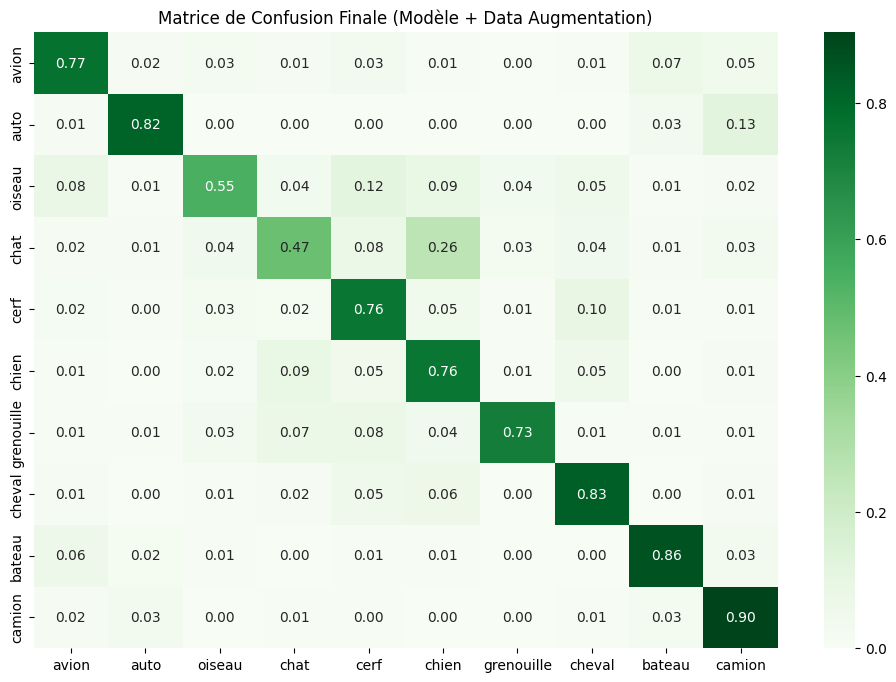

In [48]:
net_ultimate.eval() # On fige le modèle

y_pred = []
y_true = []
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Le reste du code est identique
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net_ultimate(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

        #calcul précision moyenne
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #précision par classe
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Calcul du pourcentage final
accuracy_moyenne = 100 * correct / total
print(f'Précision moyenne du modèle : {accuracy_moyenne:.2f} %')
# Affichage des résultats par classe
for i in range(10):
    print(f'Précision pour {classes[i]} : {100 * class_correct[i] / class_total[i]:.1f} %')

classes = ('avion', 'auto', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion')
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / cf_matrix.sum(axis=1)[:, None], index=classes, columns=classes)

plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='.2f') # On change en vert pour fêter le nouveau score !
plt.title('Matrice de Confusion Finale (Modèle + Data Augmentation)')
plt.show()

Grâce a ce test, on peut remarquer que la stabilisation de données a été meilleur que l'augmentation de données pour les performances du modèle.

La couche linéaire rajoutée n'a pas améliorée le modèle mais a en revanche bien modifié celui ci !

On remarque que la **précision sur le chien a énormément augmenter et que celle du chat à baisser** !

Ceci est probablement du a un effet "bottleneck", le fait de réduire a 64 a enlevé des caractéristiques définissant le chat, celui ci ressemblant beaucoup a un chien et un peu a un oiseau. 


***Je rajoute la data augmentation au modèle pour voir si elle performe tout de même ou non.***

Je la rajoute au modèle contenant 3 couches linéaires car j'estime qu'augmenter la capacité de reflexion conviendrait mieux pour la data augmentation. Je me trompe peut etre car 64 reste peu.

In [49]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chargement propre (comme on a dit, pour ne pas polluer la validation)
full_data_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
full_data_clean = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)

indices = list(range(50000))
train_indices, val_indices = indices[:40000], indices[40000:]

train_set = Subset(full_data_augmented, train_indices)
val_set = Subset(full_data_clean, val_indices)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

c:\Users\Nolan\OneDrive\Documents\projet_pytorch\venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [50]:
net_ultimate_augmente = MonReseauUltimate()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_ultimate_augmente.parameters(), lr=0.001, momentum=0.9)

In [51]:
# entraînement ultimate augmenté

# Configuration
epochs = 30
best_val_loss = float('inf') # On commence avec une erreur "infinie"

# Historiques pour les graphes
train_losses_ultimate_augmente = []
val_losses_ultimate_augmente = []

print("Lancement de l'entraînement musclé avec Data Augmentation...")

for epoch in range(epochs):
    # --- PHASE D'ENTRAÎNEMENT ---
    net_ultimate_augmente.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = net_ultimate_augmente(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # --- PHASE DE VALIDATION ---
    net_ultimate_augmente.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = net_ultimate_augmente(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Calcul des moyennes
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(val_loader)
    train_losses_ultimate_augmente.append(epoch_train_loss)
    val_losses_ultimate_augmente.append(epoch_val_loss)

    # --- SAUVEGARDE DU MEILLEUR MODÈLE ( ou Checkpoint) ---
    # Si l'erreur actuelle est plus basse que notre meilleur score historique :
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        # On enregistre les poids du réseau dans un fichier
        torch.save(net_ultimate_augmente.state_dict(), 'meilleur_modele.pth')
        print(f" Époque {epoch+1} : Nouveau meilleur modèle sauvegardé ! (Loss: {epoch_val_loss:.4f})")
    else:
        print(f"Époque {epoch+1} : Train Loss {epoch_train_loss:.4f} | Val Loss {epoch_val_loss:.4f}")

print("Entraînement terminé !")

Lancement de l'entraînement musclé avec Data Augmentation...
 Époque 1 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.4268)
 Époque 2 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.2162)
 Époque 3 : Nouveau meilleur modèle sauvegardé ! (Loss: 1.0642)
 Époque 4 : Nouveau meilleur modèle sauvegardé ! (Loss: 0.9316)
 Époque 5 : Nouveau meilleur modèle sauvegardé ! (Loss: 0.8664)
 Époque 6 : Nouveau meilleur modèle sauvegardé ! (Loss: 0.8148)
Époque 7 : Train Loss 0.8983 | Val Loss 0.8178
 Époque 8 : Nouveau meilleur modèle sauvegardé ! (Loss: 0.7524)
 Époque 9 : Nouveau meilleur modèle sauvegardé ! (Loss: 0.7500)
 Époque 10 : Nouveau meilleur modèle sauvegardé ! (Loss: 0.6947)
 Époque 11 : Nouveau meilleur modèle sauvegardé ! (Loss: 0.6842)
Époque 12 : Train Loss 0.7443 | Val Loss 0.6862
 Époque 13 : Nouveau meilleur modèle sauvegardé ! (Loss: 0.6550)
 Époque 14 : Nouveau meilleur modèle sauvegardé ! (Loss: 0.6370)
Époque 15 : Train Loss 0.6846 | Val Loss 0.6422
Époque 16 : Train Loss 0

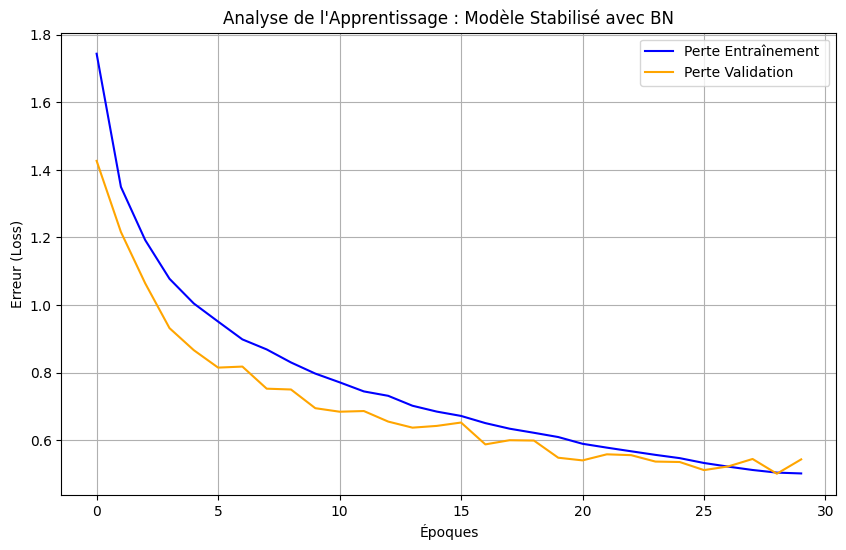

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_ultimate_augmente, label='Perte Entraînement ', color='blue')
plt.plot(val_losses_ultimate_augmente, label='Perte Validation ', color='orange')
plt.title('Analyse de l\'Apprentissage : Modèle Stabilisé avec BN')
plt.xlabel('Époques')
plt.ylabel('Erreur (Loss)')
plt.legend()
plt.grid(True)
plt.show()

Précision moyenne du modèle : 82.79 %
Précision pour avion : 87.8 %
Précision pour auto : 90.0 %
Précision pour oiseau : 74.9 %
Précision pour chat : 64.5 %
Précision pour cerf : 80.9 %
Précision pour chien : 75.8 %
Précision pour grenouille : 92.0 %
Précision pour cheval : 82.1 %
Précision pour bateau : 89.8 %
Précision pour camion : 90.1 %


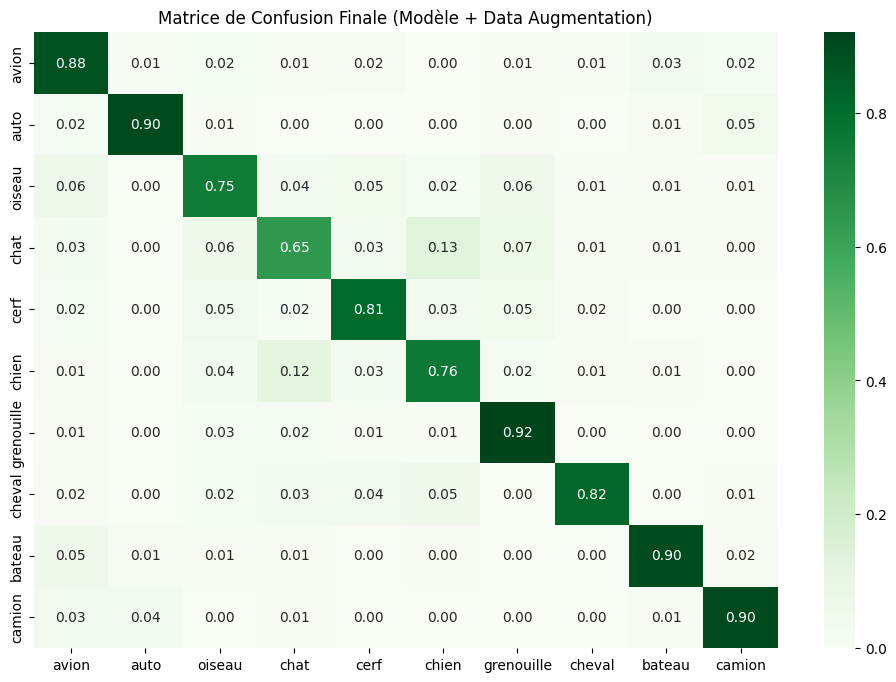

In [54]:
net_ultimate_augmente.load_state_dict(torch.load('meilleur_modele.pth'))
net_ultimate_augmente.eval() # On fige le modèle

y_pred = []
y_true = []
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Le reste du code est identique
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net_ultimate_augmente(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

        #calcul précision moyenne
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #précision par classe
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Calcul du pourcentage final
accuracy_moyenne = 100 * correct / total
print(f'Précision moyenne du modèle : {accuracy_moyenne:.2f} %')
# Affichage des résultats par classe
for i in range(10):
    print(f'Précision pour {classes[i]} : {100 * class_correct[i] / class_total[i]:.1f} %')

classes = ('avion', 'auto', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion')
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / cf_matrix.sum(axis=1)[:, None], index=classes, columns=classes)

plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='.2f') # On change en vert pour fêter le nouveau score !
plt.title('Matrice de Confusion Finale (Modèle + Data Augmentation)')
plt.show()

je veux juste voir si la data augmentation a vraiment un interet donc je regarde sur 30 epoques le modèle classique

In [57]:


class MonReseauTest(nn.Module):
    def __init__(self):
        super(MonReseauTest, self).__init__()
        # BLOC 1 : 32 filtres
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Stabilisateur
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) # Stabilisateur
        self.pool = nn.MaxPool2d(2, 2)
        
        # BLOC 2 : 64 filtres
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) # Stabilisateur
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64) # Stabilisateur
        
        # COUCHES DE DÉCISION
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10) #10 en 64
        #self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Bloc 1 : Conv -> BN -> ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Bloc 2 : Conv -> BN -> ReLU
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x=self.fc2(x)
        #x = F.relu(self.fc2(x))
        #x=self.fc3(x)
        return x

# On crée un nouveau réseau pour le modèle avec BN
net_Test = MonReseauTest()

criterion = nn.CrossEntropyLoss() # le même
optimizer = optim.SGD(net_Test.parameters(), lr=0.001, momentum=0.9) #idem

train_losses_Test = []
val_losses_Test = []

epochs = 30 #idem

#apprentissage 
print("Début de l'entraînement...")

for epoch in range(epochs):
    # --- PHASE 1 : ENTRAÎNEMENT (Apprentissage) ---
    net_Test.train() # Mode apprentissage activé
    running_train_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # A. On efface les anciens calculs de correction (Gradients)
        optimizer.zero_grad()

        # B. Passage vers l'avant (Forward) : Le réseau devine
        outputs = net_Test(inputs)

        # C. Calcul de l'erreur (Loss)
        loss = criterion(outputs, labels)

        # D. Passage vers l'arrière (Backward) : Calcul des corrections nécessaires
        loss.backward()

        # E. Mise à jour (Step) : L'optimiseur change les poids des neurones
        optimizer.step()

        running_train_loss += loss.item()

    # --- PHASE 2 : VALIDATION (Examen blanc) ---
    net_Test.eval() # Mode évaluation : on fige les neurones
    running_val_loss = 0.0
    
    with torch.no_grad(): # Désactive le calcul des gradients (gain de vitesse + mémoire)
        for data in val_loader:
            inputs, labels = data
            outputs = net_Test(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # --- PHASE 3 : DIAGNOSTIC ---
    # On calcule la perte moyenne pour cette époque
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    
    train_losses_Test.append(avg_train_loss)
    val_losses_Test.append(avg_val_loss)

    print(f"Époque [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("Entraînement terminé !")

Début de l'entraînement...
Époque [1/30] | Train Loss: 1.6016 | Val Loss: 1.3922
Époque [2/30] | Train Loss: 1.2638 | Val Loss: 1.1247
Époque [3/30] | Train Loss: 1.1204 | Val Loss: 1.0117
Époque [4/30] | Train Loss: 1.0243 | Val Loss: 0.8988
Époque [5/30] | Train Loss: 0.9607 | Val Loss: 0.8327
Époque [6/30] | Train Loss: 0.9033 | Val Loss: 0.8232
Époque [7/30] | Train Loss: 0.8612 | Val Loss: 0.7531
Époque [8/30] | Train Loss: 0.8217 | Val Loss: 0.7220
Époque [9/30] | Train Loss: 0.7866 | Val Loss: 0.6870
Époque [10/30] | Train Loss: 0.7583 | Val Loss: 0.6874
Époque [11/30] | Train Loss: 0.7306 | Val Loss: 0.6946
Époque [12/30] | Train Loss: 0.7059 | Val Loss: 0.6489
Époque [13/30] | Train Loss: 0.6857 | Val Loss: 0.6141
Époque [14/30] | Train Loss: 0.6625 | Val Loss: 0.6116
Époque [15/30] | Train Loss: 0.6431 | Val Loss: 0.6068
Époque [16/30] | Train Loss: 0.6293 | Val Loss: 0.5776
Époque [17/30] | Train Loss: 0.6113 | Val Loss: 0.5637
Époque [18/30] | Train Loss: 0.5990 | Val Loss:

Précision moyenne du modèle : 82.99 %
Précision pour avion : 82.0 %
Précision pour auto : 95.5 %
Précision pour oiseau : 79.2 %
Précision pour chat : 63.0 %
Précision pour cerf : 88.7 %
Précision pour chien : 73.7 %
Précision pour grenouille : 83.0 %
Précision pour cheval : 88.0 %
Précision pour bateau : 91.4 %
Précision pour camion : 85.4 %


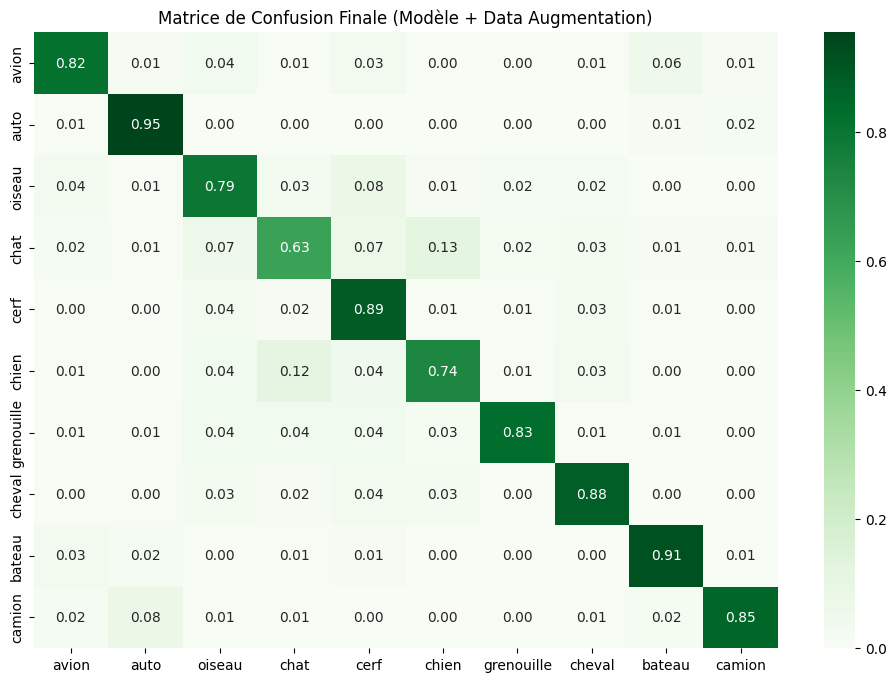

In [58]:
net_Test.eval() # On fige le modèle

y_pred = []
y_true = []
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Le reste du code est identique
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net_Test(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

        #calcul précision moyenne
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #précision par classe
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Calcul du pourcentage final
accuracy_moyenne = 100 * correct / total
print(f'Précision moyenne du modèle : {accuracy_moyenne:.2f} %')
# Affichage des résultats par classe
for i in range(10):
    print(f'Précision pour {classes[i]} : {100 * class_correct[i] / class_total[i]:.1f} %')

classes = ('avion', 'auto', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion')
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / cf_matrix.sum(axis=1)[:, None], index=classes, columns=classes)

plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='.2f') # On change en vert pour fêter le nouveau score !
plt.title('Matrice de Confusion Finale (Modèle + Data Augmentation)')
plt.show()

On remarque des résultats quasimment équivalents voir même meilleurs pour le model sans data augmentation.

Mais la Data Augmentation rend mon modèle **robuste**.

Je m'arrête là pour l'instant pour cette exploration en surface de CIPHAR-10. 